Regression to predict Arousal using FER Mean Arousal and Pupil size. (Using the new FER method)

Mounting drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

# Data paths and reading the ground truth

Defining the data paths for features (full video and intervals)

In [ ]:
# Change to the corresponding directory where you have the features files -- only change here for the new FER folder

full_video_directory = r"/content/drive/MyDrive/Data-Multimotion/Features-NEW/Full"

intervals_directory = r"/content/drive/MyDrive/Data-Multimotion/Features-NEW/Intervals"

ground_truth_directory = r"/content/drive/MyDrive/Data-Multimotion/Ground truth"

results_folder = r"/content/drive/MyDrive/Data-Multimotion/Results"

Reading the ground truth:

In [ ]:
ground_truth = pd.read_csv(os.path.join(ground_truth_directory, "individual_ground_truth.csv"))

In [ ]:
ground_truth.head()

,Participant,Stimulus_Name,Valence,Arousal
0,GFGzP,HN_1,-1.229518,0.213407
1,GFGzP,HN_2_H,-0.913097,0.273113
2,GFGzP,HN_2_L,-0.159682,-0.320677
3,GFGzP,HN_3_H,-0.857831,0.284121
4,GFGzP,HN_3_L,-0.082370,-0.324416


# Helper functions

In [ ]:
def calculate_rmse(y_true, y_pred):
    """ Function to calculate the RMSE. """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
def normalize_column(df, column_name, min_val, max_val):
    """ Function to normalize with Min Max. """
    # Scale to [0, 1], then shift and scale to [-1, 1]
    return 2 * ((df[column_name] - min_val) / (max_val - min_val + 1e-8)) - 1

In [ ]:
def filter_fer_data(fer_full):
    """ Function to filter FER data. """
    # Selecting relevant columns
    df_fer_full = fer_full[["participant", "video", "FER_Mean_Arousal"]]

    # Identify participants with NaNs in 'FER_Mean_Arousal'
    participants_with_nan = df_fer_full[df_fer_full["FER_Mean_Arousal"].isna()]["participant"].unique()

    # Displaying the participants that were discarded
    if len(participants_with_nan) > 0:
        print("\nThe following participants have been discarded due to NaN values in FER_Mean_Arousal:")
        for participant in participants_with_nan:
            print(participant)
    else:
        print("\nNo participants with NaN values in FER_Mean_Arousal.")

    # Eliminate all rows for participants with any NaNs in FER_Mean_Arousal
    df_fer_full_clean = df_fer_full[~df_fer_full["participant"].isin(participants_with_nan)]

    return df_fer_full_clean


In [ ]:
def filter_pupil_size_data(pupil_full):
    """ Function to filter pupil data. """
    # Selecting only the relevant columns
    df_pupil_full = pupil_full[["participant", "video", "Pupil_size"]]

    # Identify participants with NaNs in 'Pupil_size'
    participants_with_nan = df_pupil_full[df_pupil_full["Pupil_size"].isna()]["participant"].unique()

    # Displaying the participants that were discarded
    if len(participants_with_nan) > 0:
        print("\nThe following participants have been discarded due to NaN values in Pupil_size:")
        for participant in participants_with_nan:
            print(participant)
    else:
        print("\nNo participants with NaN values in Pupil_size.")

    # Eliminate all rows for participants with any NaNs in Pupil_size
    df_pupil_full_clean = df_pupil_full[~df_pupil_full["participant"].isin(participants_with_nan)]

    # Return the cleaned DataFrame
    return df_pupil_full_clean


**Ground truth**

In [ ]:
def load_gt_for_lopo(gt_folder, test_participant_id):
    """
    Loading the correct ground truth files for LOPO.

    Parameters:
    - gt_folder: Path to folder containing the GT files
    - test_participant_id: unique ID of the participant used as the test set

    Returns:
    - gt_for_test: Ground Truth DataFrame including the test participant (individual_ground_truth.csv)
    - gt_for_others: Ground Druth DataFrame excluding the test participant (this is because INDSCAL depends on the set of participants used)
    """

    # Loading GT including the test participant
    gt_including_test_path = os.path.join(gt_folder, "individual_ground_truth.csv")
    gt_for_test = pd.read_csv(gt_including_test_path)

    # Loading GT excluding the test participant
    gt_excluding_test_path = os.path.join(gt_folder + f"/Leave-one-out/individual_ground_truth_no_{test_participant_id}.csv")
    if not os.path.exists(gt_excluding_test_path):
        raise FileNotFoundError(f"Missing GT file: {gt_excluding_test_path}")

    gt_for_others = pd.read_csv(gt_excluding_test_path)

    return gt_for_test, gt_for_others


**Perform the Leave One Participant Out regression:**

In [ ]:
def leave_one_out_regression(data, feature_column, gt_folder):
    """Perform regression using LOPO method with Min-Max normalization and using the correct GT."""
    results = []
    respondents = data['participant'].unique()

    # Iterating the participants
    for respondent in respondents:
        # Loading the GT files
        try:
            gt_for_test, gt_for_others = load_gt_for_lopo(gt_folder, respondent)
        except FileNotFoundError as e:
            print(f"{e} Skipping {respondent}.")
            continue

        # Train/test splitting --- test is the left out participant
        train_data = data[data['participant'] != respondent]
        test_data = data[data['participant'] == respondent]

        if len(train_data) < 2:
            print(f"Not enough data excluding participant {respondent}. Skipping...")
            continue

        # Min-Max normalization from training set
        min_val = train_data[feature_column].min()
        max_val = train_data[feature_column].max()

        if min_val == max_val:
            print(f"Cannot normalize feature for participant {respondent} — zero range. Skipping...")
            continue

        # Normalizing both train and test sets
        train_data = train_data.copy()
        test_data = test_data.copy()
        train_data[feature_column + "_norm"] = normalize_column(train_data, feature_column, min_val, max_val)
        test_data[feature_column + "_norm"] = normalize_column(test_data, feature_column, min_val, max_val)

        # Merge GT to get correct arousal for test participant
        # Rename for merging if necessary
        gt_for_test = gt_for_test.rename(columns={'Stimulus_Name': 'video'})
        test_data = pd.merge(test_data, gt_for_test[['video', 'Arousal']], on='video', how='left')

        # Merge GT to get correct arousal for train participants
        # Rename for merging if necessary
        gt_for_others = gt_for_others.rename(columns={'Stimulus_Name': 'video'})
        train_data = pd.merge(train_data, gt_for_others[['video', 'Arousal']], on='video', how='left')

        if test_data['Arousal'].isna().any():
            print(f"Missing GT values for participant {respondent}. Skipping...")
            continue

        # Regression on training data
        try:
            m, c = np.polyfit(train_data['Arousal'], train_data[feature_column + "_norm"], 1)
        except Exception as e:
            print(f"Error in polyfit for participant {respondent}: {e}. Skipping...")
            continue

        if m == 0:
            print(f"Invalid regression coefficients for participant {respondent}. Skipping...")
            continue

        for _, row in test_data.iterrows():
            predicted_arousal = (row[feature_column + "_norm"] - c) / m

            # Append results
            results.append({
                'participant': respondent,
                'Stimuli_Name': row['video'],
                f'Predicted_arousal_{feature_column}': predicted_arousal,
                'Arousal': row['Arousal'],  # from GT file
                feature_column: row[feature_column],
                f'{feature_column}_norm': row[feature_column + "_norm"]
            })

    return pd.DataFrame(results)

**Function to calculate the R2 score, RMSE, NRMSE, p-value and correlation:**

In [ ]:
def calculate_and_plot_metrics(df, feature_column, type_video, results_folder, gt_folder):
    """Calculate regression metrics (RMSE, NRMSE, R2, p-value and correlation) for each participant using LOPO Ground Truth."""
    results = []
    participants = df['participant'].unique()

    # Iterating through the participants
    for participant in participants:
        df_participant = df[df['participant'] == participant].copy()

        if df_participant['Arousal'].isna().any():
            print(f"Missing GT Arousal values for participant {participant}. Skipping...")
            continue

        # Reshaping the arousal column for regression
        X = df_participant['Arousal'].values.reshape(-1, 1)
        y_feature = df_participant[f'Predicted_arousal_{feature_column}']

        # Check for and drop invalid entries
        valid_idx = (~np.isnan(X.flatten())) & (~np.isnan(y_feature)) & (~np.isinf(y_feature))
        X = X[valid_idx]
        y_feature = y_feature[valid_idx]

        if len(X) == 0:
            print(f"No valid data for participant {participant}. Skipping...")
            continue

        # Train regression
        model_feature = LinearRegression().fit(X, y_feature)
        r2_feature = model_feature.score(X, y_feature)
        rmse_feature = np.sqrt(np.mean((X.flatten() - y_feature) ** 2))

        arousal_range = X.max() - X.min()
        if arousal_range == 0:
            print(f"Zero range in Arousal for participant {participant}. Skipping...")
            continue
        nrmse_feature = rmse_feature / arousal_range

        correlation_feature, p_value_feature = pearsonr(X.flatten(), y_feature)

        # Plot the GT and the predicted values (and evaluation metrics)
        fig, ax = plt.subplots()
        sns.regplot(x=X.flatten(), y=y_feature, color='blue', ci=0, ax=ax, label=f'{feature_column}')

        title = (f"{type_video.capitalize()} \n"
                 f"{participant if participant else 'All Participants'}, \n"
                 f"R2 {feature_column}: {r2_feature:.4f}\n"
                 f"NRMSE {feature_column}: {nrmse_feature:.4f}\n"
                 f"Corr {feature_column}: {correlation_feature:.4f}\n"
                 f"P-value {feature_column}: {p_value_feature:.4f}")

        ax.set_title(title)
        ax.set_xlabel('Ground Truth Arousal')
        ax.set_ylabel(f'Predicted {feature_column}')
        plt.legend()
        plt.grid()

        # Make sure the directory exists
        plot_path = os.path.join(results_folder, "Plots", "LeaveOneOut(FER-Pupil)")
        os.makedirs(plot_path, exist_ok=True)
        plot_filename = os.path.join(plot_path, f"{participant}_plot_{type_video}.png")
        plt.tight_layout()
        plt.savefig(plot_filename)
        plt.close(fig)

        # Append results
        results.append({
            'Participant': participant,
            f'R2_{feature_column}': r2_feature,
            f'RMSE_{feature_column}': rmse_feature,
            f'NRMSE_{feature_column}': nrmse_feature,
            f'Corr_{feature_column}': correlation_feature,
            f'P_value_{feature_column}': p_value_feature,
        })

    return pd.DataFrame(results)

In [ ]:
def calculate_lopo_regression_metrics_with_gt(data, gt_folder):
    """ Function to calculate metrics for predicting Arousal using both Pupil_size and FER_Mean_Arousal with Leave-One-Out Cross-Validation """
    results = []
    participants = data['participant'].unique()

    for participant in participants:
        # Load GT data using the provided function
        try:
            gt_test, gt_train = load_gt_for_lopo(gt_folder, participant)
        except Exception as e:
            print(f"Error loading GT for participant {participant}: {e}")
            continue
        # Rename for merging if necessary
        gt_train = gt_train.rename(columns={'Participant': 'participant'})
        gt_train = gt_train.rename(columns={'Stimulus_Name': 'video'})
        gt_test = gt_test.rename(columns={'Participant': 'participant'})
        gt_test = gt_test.rename(columns={'Stimulus_Name': 'video'})

        # Merge GT with main data
        df_train = data[data['participant'] != participant].merge(gt_train, on=['participant', 'video'], how='inner')
        df_test = data[data['participant'] == participant].merge(gt_test, on=['participant', 'video'], how='inner')

        if df_train.empty or df_test.empty:
            print(f"Skipping participant {participant} due to empty merged GT.")
            continue

        # Normalize features using training set stats
        features = ['Pupil_size', 'FER_Mean_Arousal']
        skip = False
        for feature in features:
            min_val = df_train[feature].min()
            max_val = df_train[feature].max()
            if min_val == max_val:
                print(f"Zero range for {feature} in training. Skipping participant {participant}.")
                skip = True
                break
            df_train[feature + '_norm'] = normalize_column(df_train, feature, min_val, max_val)
            df_test[feature + '_norm'] = normalize_column(df_test, feature, min_val, max_val)

        if skip:
            continue

        # Regression using Pupil and FER_Mean_Arousal (2 variables)
        X_train = df_train[['Pupil_size_norm', 'FER_Mean_Arousal_norm']].values
        y_train = df_train['Arousal'].values
        X_train = np.c_[np.ones(X_train.shape[0]), X_train]

        try:
            beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
        except Exception as e:
            print(f"Regression error for participant {participant}: {e}")
            continue

        b0, b1, b2 = beta

        X_test = df_test[['Pupil_size_norm', 'FER_Mean_Arousal_norm']].values
        X_test = np.c_[np.ones(X_test.shape[0]), X_test]
        y_pred = X_test @ beta
        y_test = df_test['Arousal'].values

        if len(y_test) < 2:
            print(f"Too few samples for participant {participant}. Skipping.")
            continue

        # Calculate metrics
        ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
        ss_residual = np.sum((y_test - y_pred) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        range_y = np.max(y_test) - np.min(y_test)
        nrmse = rmse / range_y if range_y != 0 else np.nan
        corr, p_value = pearsonr(y_test, y_pred)

        # Append results
        results.append({
            'Participant': participant,
            'Intercept': b0,
            'Coef_Pupil_Size': b1,
            'Coef_FER_Mean_Arousal': b2,
            'R2': r2,
            'RMSE': rmse,
            'NRMSE': nrmse,
            'Correlation': corr,
            'P_value': p_value
        })

    return pd.DataFrame(results)


In [ ]:
def plot_coefficients(results_df, video_type):
    """ Plot regression coefficients/weights for each participant. """"
    # Make the DataFrame to long-form for easier plotting
    coeffs_long = results_df.melt(
        id_vars='Participant',
        value_vars=['Coef_Pupil_Size', 'Coef_FER_Mean_Arousal'],
        var_name='Feature',
        value_name='Coefficient'
    )

    # Sort participants to keep plots consistent
    coeffs_long['Participant'] = pd.Categorical(coeffs_long['Participant'], ordered=True)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=coeffs_long, x='Participant', y='Coefficient', hue='Feature')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Regression Coefficients by Participant (LOPO) {video_type}')
    plt.ylabel('Coefficient Value')
    plt.xlabel('Participant')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.legend(title='Feature')
    plt.show()

# Full videos

Performing regression on the features extracted from the **whole videos**.

## Loading data

Loading FER and Pupil csv and checking if they loaded properly.

In [ ]:
fer_full = pd.read_csv(os.path.join(full_video_directory, "FER_features.csv"))
pupil_full = pd.read_csv(os.path.join(full_video_directory, "Pupil_size.csv"))

In [ ]:
fer_full.head()

,participant,video,FER_Mean_Valence,FER_Mean_Arousal,FER_Std_Valence,FER_Std_Arousal,FER_Kurtosis_Valence,FER_Kurtosis_Arousal,FER_Max_Valence,FER_Max_Arousal,FER_Min_Valence,FER_Min_Arousal
0,7yqP3,HN_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7yqP3,HP_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7yqP3,HN_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7yqP3,HP_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7yqP3,HP_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pupil_full.head()

,participant,video,Pupil_size
0,7yqP3,HN_1,0.000565
1,7yqP3,HN_2_H,0.234586
2,7yqP3,HN_2_L,-0.559571
3,7yqP3,HN_3_H,0.028981
4,7yqP3,HN_3_L,-0.032024


## FER Mean Arousal

LOPO regression using only the "FER_Mean_Arousal" feature.

In [ ]:
print("Number of participants before processing:", len(fer_full['participant'].unique()))

Number of participants before processing: 47


In [ ]:
df_fer_mean_arousal_full = filter_fer_data(fer_full)


The following participants have been discarded due to NaN values in FER_Mean_Arousal:
7yqP3
WYuvqk
h2yD5h
XPI3pA
GHft8


In [ ]:
lopo_fer_mean_arousal_full = leave_one_out_regression(df_fer_mean_arousal_full, "FER_Mean_Arousal", ground_truth_directory)

In [ ]:
lopo_fer_mean_arousal_full_metrics = calculate_and_plot_metrics(lopo_fer_mean_arousal_full, "FER_Mean_Arousal","Full video",results_folder, ground_truth_directory)

In [ ]:
lopo_fer_mean_arousal_full_metrics.head()

,Participant,R2_FER_Mean_Arousal,RMSE_FER_Mean_Arousal,NRMSE_FER_Mean_Arousal,Corr_FER_Mean_Arousal,P_value_FER_Mean_Arousal
0,F5tXL,0.128734,1.937502,1.892044,0.358795,2.159429e-55
1,Gax8,0.062946,0.714830,0.698058,0.250891,4.864192e-27
2,Hx7dO,0.051103,3.246911,3.170731,0.226060,3.952418e-22
3,wohkw,0.024027,0.726665,0.709615,0.155005,4.519870e-11
4,G4dLl,0.034319,1.839139,1.795989,0.185254,2.974598e-15


In [ ]:
lopo_fer_mean_arousal_full_metrics.describe()

,R2_FER_Mean_Arousal,RMSE_FER_Mean_Arousal,NRMSE_FER_Mean_Arousal,Corr_FER_Mean_Arousal,P_value_FER_Mean_Arousal
count,42.000000,42.000000,42.000000,42.000000,4.200000e+01
mean,0.055992,1.282988,1.252887,0.172684,6.458126e-03
std,0.050815,0.763932,0.746009,0.163739,3.338477e-02
min,0.000861,0.579072,0.565486,-0.224790,3.434216e-81
25%,0.024176,0.658827,0.643369,0.133234,9.277851e-27
50%,0.042528,1.025432,1.001373,0.191271,1.583228e-18
75%,0.062547,1.711092,1.670946,0.250090,4.037054e-11
max,0.197804,3.246911,3.170731,0.444752,2.152182e-01


## Pupil

LOPO regression using only the "Pupil_size" feature.

In [ ]:
print("Number of participants before processing:", len(pupil_full['participant'].unique()))

Number of participants before processing: 47


In [ ]:
df_pupil_size_full = filter_pupil_size_data(pupil_full)


The following participants have been discarded due to NaN values in Pupil_size:
Fyt7d


In [ ]:
lopo_pupil_size_full = leave_one_out_regression(df_pupil_size_full, "Pupil_size", ground_truth_directory)

In [ ]:
lopo_pupil_size_full_metrics = calculate_and_plot_metrics(lopo_pupil_size_full,"Pupil_size","Full video",results_folder, ground_truth_directory)

In [ ]:
lopo_pupil_size_full_metrics.head()

,Participant,R2_Pupil_size,RMSE_Pupil_size,NRMSE_Pupil_size,Corr_Pupil_size,P_value_Pupil_size
0,7yqP3,0.174810,2.815700,2.749637,0.418103,1.658428e-76
1,F5tXL,0.032647,0.382157,0.373190,0.180685,1.426043e-14
2,Gax8,0.169170,2.509243,2.450370,0.411303,7.339480e-74
3,Hx7dO,0.160395,0.657915,0.642479,0.400493,8.856607e-70
4,wohkw,0.185538,0.575046,0.561554,0.430741,1.372759e-81


In [ ]:
lopo_pupil_size_full_metrics.describe()

,R2_Pupil_size,RMSE_Pupil_size,NRMSE_Pupil_size,Corr_Pupil_size,P_value_Pupil_size
count,46.000000,46.000000,46.000000,46.000000,4.600000e+01
mean,0.165337,1.221057,1.192849,0.400569,3.100094e-16
std,0.051089,0.907580,0.885911,0.070635,2.102585e-15
min,0.032647,0.259418,0.253331,0.180685,2.471898e-117
25%,0.141413,0.513531,0.506529,0.376015,3.453199e-91
50%,0.170063,0.820926,0.801665,0.412385,1.981667e-73
75%,0.205429,1.939568,1.894061,0.453242,3.253206e-60
max,0.257191,4.115894,4.019326,0.507140,1.426043e-14


## Saving to csv

Saving the results for **FULL VIDEO** FER_Mean_Arousal and Pupil_size Leave One Out Regression to a csv (each feature used separately).

In [ ]:
# Outer join (keeping all participants from both DataFrames)
full_videos_lopo_results = pd.merge(lopo_pupil_size_full_metrics, lopo_fer_mean_arousal_full_metrics,
                           on="Participant", how="outer")

# Show the first few rows of the merged DataFrame
full_videos_lopo_results.head()

,Participant,R2_Pupil_size,RMSE_Pupil_size,NRMSE_Pupil_size,Corr_Pupil_size,P_value_Pupil_size,R2_FER_Mean_Arousal,RMSE_FER_Mean_Arousal,NRMSE_FER_Mean_Arousal,Corr_FER_Mean_Arousal,P_value_FER_Mean_Arousal
0,4FoNM,0.205949,2.663795,2.601296,0.453816,1.919639e-91,0.049381,0.630912,0.616109,0.222217,2.026856e-21
1,5KB3V,0.167793,1.729424,1.688847,0.409625,3.229386e-73,0.184008,2.862596,2.795433,0.428962,7.350328e-81
2,6GSd4,0.218542,0.288715,0.281941,0.467484,1.195550e-97,0.048062,1.397643,1.364851,0.219230,7.073133e-21
3,7yqP3,0.174810,2.815700,2.749637,0.418103,1.658428e-76,NaN,NaN,NaN,NaN,NaN
4,8vDRG,0.124964,0.872506,0.852035,0.353502,1.031018e-53,0.025372,0.780635,0.762319,0.159287,1.286206e-11


In [ ]:
# Saving the metrics to a csv
full_videos_lopo_results.to_csv(results_folder + "/full_video_leave-one-out-METRICS.csv", header=True)

## Both (FER Mean Arousal and Pupil_size)

LOPO regression using the "FER_Mean_Arousal" and "Pupil_size" features.

In [ ]:
# Merge the dataFrames on both 'Participant' and 'video'
df_full = pd.merge(fer_full, pupil_full, on=["participant", "video"], how="inner")

df_full = df_full[['participant','video','FER_Mean_Arousal', 'Pupil_size']]

# Show the first few rows of the merged DataFrame
df_full.head()

,participant,video,FER_Mean_Arousal,Pupil_size
0,7yqP3,HN_7,NaN,0.000557
1,7yqP3,HP_2,NaN,-0.000076
2,7yqP3,HN_6,NaN,-0.000009
3,7yqP3,HP_9,NaN,0.000100
4,7yqP3,HP_4,NaN,0.000230


In [ ]:
# Find participants with any NaNs in their rows
participants_with_nans = df_full[df_full.isna().any(axis=1)]['participant'].unique()

# Remove all the rows for those participants
df_full_cleaned = df_full[~df_full['participant'].isin(participants_with_nans)]

# Display the participants that were removed
print("Participants completely removed due to NaNs:")
print(participants_with_nans)
print(f"Total participants removed: {len(participants_with_nans)}")

Participants completely removed due to NaNs:
['7yqP3' 'WYuvqk' 'h2yD5h' 'XPI3pA' 'Fyt7d' 'GHft8']
Total participants removed: 6


In [ ]:
results_lopo_full = calculate_lopo_regression_metrics_with_gt(df_full_cleaned, ground_truth_directory)

In [ ]:
results_lopo_full.describe()

,Intercept,Coef_Pupil_Size,Coef_FER_Mean_Arousal,R2,RMSE,NRMSE,Correlation,P_value
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-0.044180,0.557274,0.133528,0.130440,0.241581,0.321597,0.428460,0.016728
std,0.044726,0.278778,0.018775,0.112670,0.043923,0.019041,0.069581,0.028161
min,-0.103685,0.159639,0.088115,-0.467224,0.153695,0.300133,0.263806,0.000447
25%,-0.079784,0.175715,0.123807,0.087979,0.215102,0.311046,0.401060,0.002768
50%,-0.073162,0.749048,0.131903,0.149432,0.240588,0.317396,0.445438,0.005070
75%,0.015107,0.761660,0.140158,0.192364,0.271408,0.330276,0.472075,0.013322
max,0.022318,0.780651,0.209846,0.244528,0.340877,0.418265,0.541486,0.109514


In [ ]:
# Save the metrics to a csv
results_lopo_full.to_csv(results_folder + "/full_video_both-fer-pupil_leave-one-out-METRICS.csv", header=True)

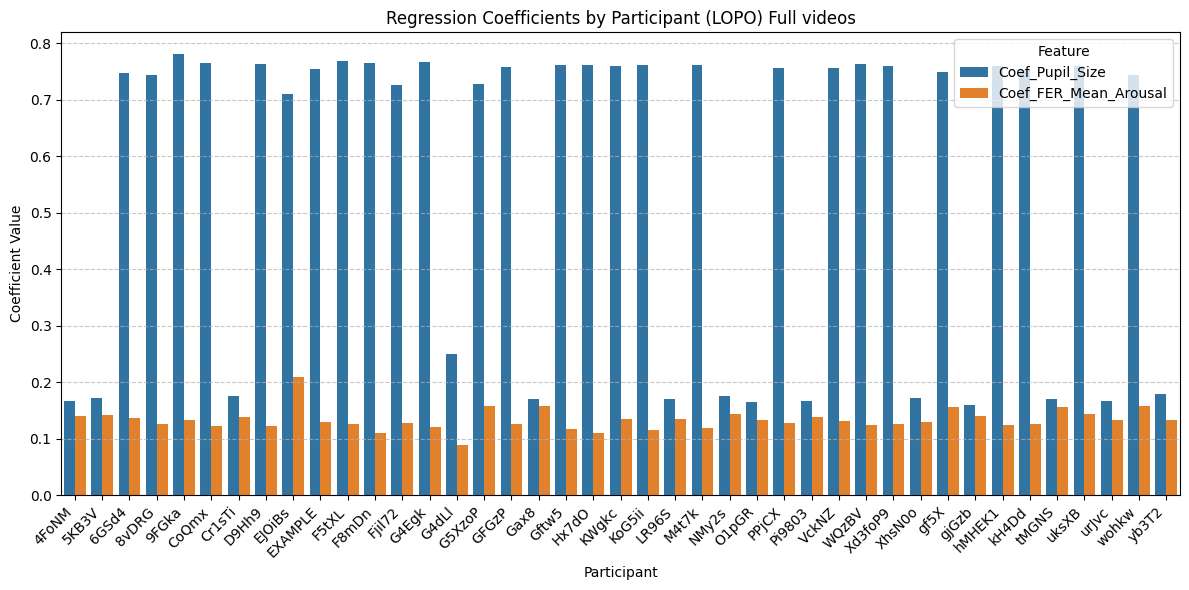

In [ ]:
plot_coefficients(results_lopo_full, "Full videos")

# Intervals

I will perform regression on the features extracted from **intervals** from videos (not whole videos, considering only certain parts).

## Loading data

Loading FER and Pupil csv and checking if they loaded properly.

In [ ]:
fer_intervals = pd.read_csv(os.path.join(intervals_directory, "FER_features.csv"))
pupil_intervals = pd.read_csv(os.path.join(intervals_directory, "Pupil_size.csv"))

In [ ]:
fer_intervals.head()

,participant,video,FER_Mean_Valence,FER_Mean_Arousal,FER_Std_Valence,FER_Std_Arousal,FER_Kurtosis_Valence,FER_Kurtosis_Arousal,FER_Max_Valence,FER_Max_Arousal,FER_Min_Valence,FER_Min_Arousal
0,7yqP3,HN_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7yqP3,HP_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7yqP3,HN_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7yqP3,HP_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7yqP3,HP_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pupil_intervals.head()

,participant,video,Pupil_size
0,7yqP3,HN_1,0.000565
1,7yqP3,HN_2_H,0.264199
2,7yqP3,HN_2_L,-0.559571
3,7yqP3,HN_3_H,-0.008750
4,7yqP3,HN_3_L,-0.046637


## FER Mean Arousal

LOPO regression using only the "FER_Mean_Arousal" feature.

In [ ]:
print("Number of participants before processing:", len(fer_intervals['participant'].unique()))

Number of participants before processing: 47


In [ ]:
df_fer_mean_arousal_intervals = filter_fer_data(fer_intervals)


The following participants have been discarded due to NaN values in FER_Mean_Arousal:
7yqP3
WYuvqk
h2yD5h
XPI3pA
GHft8


In [ ]:
lopo_fer_mean_arousal_intervals = leave_one_out_regression(df_fer_mean_arousal_intervals, "FER_Mean_Arousal", ground_truth_directory)

In [ ]:
lopo_fer_mean_arousal_intervals_metrics = calculate_and_plot_metrics(lopo_fer_mean_arousal_intervals, "FER_Mean_Arousal","Intervals",results_folder, ground_truth)

In [ ]:
lopo_fer_mean_arousal_intervals_metrics.head()

,Participant,R2_FER_Mean_Arousal,RMSE_FER_Mean_Arousal,NRMSE_FER_Mean_Arousal,Corr_FER_Mean_Arousal,P_value_FER_Mean_Arousal
0,F5tXL,0.093290,2.158049,2.107416,0.305434,7.093584e-40
1,Gax8,0.054986,0.726212,0.709174,0.234490,9.840709e-24
2,Hx7dO,0.010985,3.469492,3.388090,0.104811,9.055783e-06
3,wohkw,0.002736,0.833933,0.814367,0.052310,2.705956e-02
4,G4dLl,0.011298,2.044717,1.996743,0.106290,6.745579e-06


In [ ]:
lopo_fer_mean_arousal_intervals_metrics.describe()

,R2_FER_Mean_Arousal,RMSE_FER_Mean_Arousal,NRMSE_FER_Mean_Arousal,Corr_FER_Mean_Arousal,P_value_FER_Mean_Arousal
count,42.000000,42.000000,42.000000,42.000000,4.200000e+01
mean,0.046117,1.431385,1.397801,0.155715,3.202136e-02
std,0.048870,0.913794,0.892354,0.149677,1.199322e-01
min,0.000068,0.600374,0.586288,-0.200056,2.532578e-75
25%,0.011826,0.672811,0.657025,0.081664,7.450817e-23
50%,0.030029,1.065066,1.040078,0.153044,2.968238e-12
75%,0.054117,1.980110,1.933652,0.232607,5.290262e-06
max,0.178453,3.483460,3.401730,0.422437,7.278976e-01


## Pupil

LOPO regression using only the "Pupil_size" feature.

In [ ]:
print("Number of participants before processing:", len(pupil_intervals['participant'].unique()))

Number of participants before processing: 47


In [ ]:
df_pupil_size_intervals = filter_pupil_size_data(pupil_intervals)


The following participants have been discarded due to NaN values in Pupil_size:
Fyt7d


In [ ]:
lopo_pupil_size_intervals = leave_one_out_regression(df_pupil_size_intervals, "Pupil_size", ground_truth_directory)

In [ ]:
lopo_pupil_size_intervals_metrics = calculate_and_plot_metrics(lopo_pupil_size_intervals,"Pupil_size","Intervals",results_folder, ground_truth_directory)

In [ ]:
lopo_pupil_size_intervals_metrics.head()

,Participant,R2_Pupil_size,RMSE_Pupil_size,NRMSE_Pupil_size,Corr_Pupil_size,P_value_Pupil_size
0,7yqP3,0.280738,0.483138,0.471802,0.529847,7.851297e-130
1,F5tXL,0.166379,0.266949,0.260685,0.407896,1.473979e-72
2,Gax8,0.475894,0.481299,0.470007,0.689851,1.442433e-252
3,Hx7dO,0.505436,0.269124,0.262810,0.710940,4.684814e-275
4,wohkw,0.473371,0.260816,0.254697,0.688020,1.047683e-250


In [ ]:
lopo_pupil_size_intervals_metrics.describe()

,R2_Pupil_size,RMSE_Pupil_size,NRMSE_Pupil_size,Corr_Pupil_size,P_value_Pupil_size
count,46.000000,46.000000,46.000000,46.000000,4.600000e+01
mean,0.416390,0.378219,0.369581,0.637049,3.698844e-34
std,0.119787,0.140696,0.137181,0.103887,2.508678e-33
min,0.080008,0.189627,0.187989,0.282858,0.000000e+00
25%,0.338111,0.273003,0.266598,0.581473,7.199645e-260
50%,0.460927,0.355091,0.346760,0.678916,2.062689e-236
75%,0.493064,0.449647,0.439097,0.702185,4.536571e-162
max,0.600098,0.851754,0.831770,0.774660,1.701468e-32


## Saving to csv

Saving the results for intervals FER_Mean_Arousal and Pupil_size Leave One Out Regression to a csv (each feature used separately).

In [ ]:
# Outer join (keep all participants from both DataFrames)
intervals_lopo_results = pd.merge(lopo_pupil_size_intervals_metrics, lopo_fer_mean_arousal_intervals_metrics,
                           on="Participant", how="outer")

# Displaying the first few rows of the merged DataFrame
intervals_lopo_results.head()

,Participant,R2_Pupil_size,RMSE_Pupil_size,NRMSE_Pupil_size,Corr_Pupil_size,P_value_Pupil_size,R2_FER_Mean_Arousal,RMSE_FER_Mean_Arousal,NRMSE_FER_Mean_Arousal,Corr_FER_Mean_Arousal,P_value_FER_Mean_Arousal
0,4FoNM,0.462010,0.453151,0.442519,0.679714,1.967101e-242,0.021225,0.651907,0.636611,-0.145687,6.185878e-10
1,5KB3V,0.453232,0.293642,0.286753,0.673225,3.701554e-236,0.166062,3.354110,3.275415,0.407507,2.071036e-72
2,6GSd4,0.365311,0.215207,0.210158,0.604409,2.393706e-178,0.035392,1.411273,1.378162,0.188129,1.086749e-15
3,7yqP3,0.280738,0.483138,0.471802,0.529847,7.851297e-130,NaN,NaN,NaN,NaN,NaN
4,8vDRG,0.250946,0.412219,0.402547,0.500946,4.376625e-114,0.013411,0.970017,0.947258,0.115804,9.243114e-07


In [ ]:
# Save the metrics to a csv
intervals_lopo_results.to_csv(results_folder + "/intervals_leave-one-out-METRICS.csv", header=True)

## Both (FER Mean Arousal and Pupil_size)

LOPO regression using both the "FER_Mean_Arousal" and "Pupil_size" features.

In [ ]:
# Merge the two dataFrames on both 'Participant' and 'video'
df_intervals = pd.merge(fer_intervals, pupil_intervals, on=["participant", "video"], how="inner")

df_intervals = df_intervals[['participant','video','FER_Mean_Arousal', 'Pupil_size']]

# Displaying the first few rows of the dataFrame
df_intervals.head()

,participant,video,FER_Mean_Arousal,Pupil_size
0,7yqP3,HN_7,NaN,-0.070657
1,7yqP3,HP_2,NaN,0.007374
2,7yqP3,HN_6,NaN,-0.002016
3,7yqP3,HP_9,NaN,0.000807
4,7yqP3,HP_4,NaN,0.079303


In [ ]:
# Find participants with any NaNs in their rows
participants_with_nans = df_intervals[df_intervals.isna().any(axis=1)]['participant'].unique()

# Remove all rows for those participants
df_intervals_cleaned = df_intervals[~df_intervals['participant'].isin(participants_with_nans)]

# Displaying the participants that were removed
print("Participants completely removed due to NaNs:")
print(participants_with_nans)

Participants completely removed due to NaNs:
['7yqP3' 'WYuvqk' 'h2yD5h' 'XPI3pA' 'Fyt7d' 'GHft8']


In [ ]:
results_lopo_intervals = calculate_lopo_regression_metrics_with_gt(df_intervals_cleaned, ground_truth_directory)

In [ ]:
results_lopo_intervals.describe()

,Intercept,Coef_Pupil_Size,Coef_FER_Mean_Arousal,R2,RMSE,NRMSE,Correlation,P_value
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,4.100000e+01
mean,-0.150745,0.753240,0.061546,0.358582,0.206384,0.274571,0.656784,4.099426e-04
std,0.033185,0.142090,0.014692,0.179289,0.042787,0.034004,0.092298,1.197957e-03
min,-0.200389,0.539674,0.029529,-0.542045,0.115745,0.225115,0.436036,1.721140e-08
25%,-0.175227,0.563383,0.052387,0.276896,0.181835,0.252893,0.597656,5.467552e-07
50%,-0.172746,0.840614,0.059693,0.377217,0.199948,0.272503,0.691995,1.493508e-06
75%,-0.107318,0.856788,0.067607,0.467193,0.233595,0.293632,0.718637,7.432237e-05
max,-0.098409,0.894332,0.120653,0.574989,0.302569,0.428797,0.768852,6.208487e-03


In [ ]:
# Save the metrics to a csv
results_lopo_intervals.to_csv(results_folder + "/intervals_both-fer-pupil_leave-one-out-METRICS.csv", header=True)

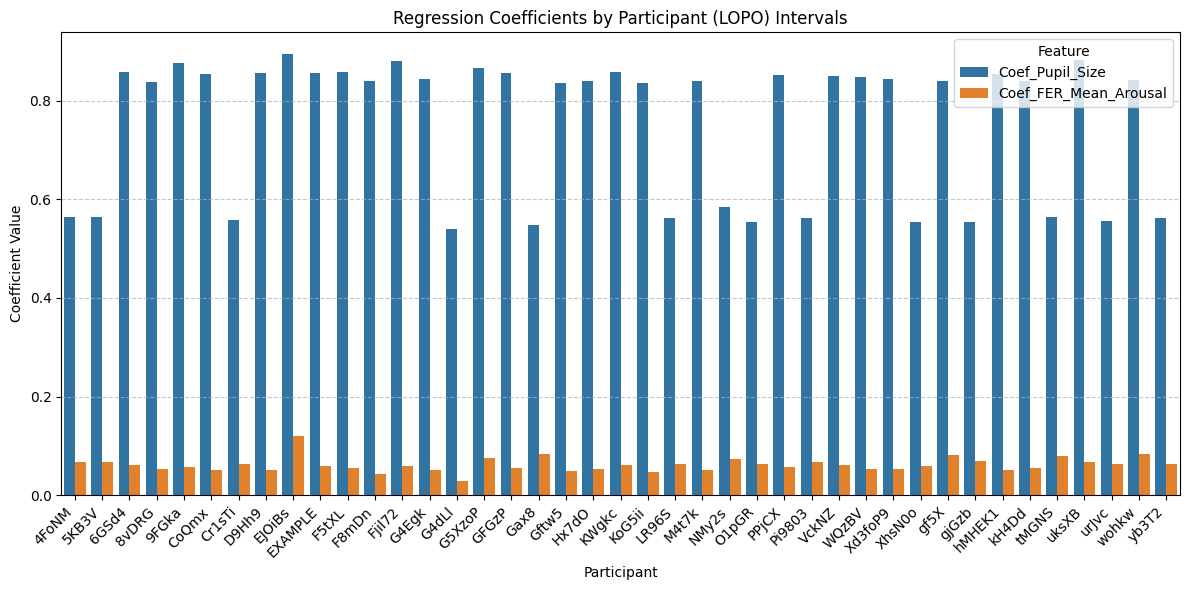

In [ ]:
plot_coefficients(results_lopo_intervals, "Intervals")